In [1]:
!pip install --upgrade imbalanced-learn==0.10.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50  
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2025-10-25 21:42:35.561747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761428555.755698      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761428555.812325      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_dir = "/kaggle/input/resnet-50ppmi-datscan1/DAT-SEGREGATION"
print(os.listdir(data_dir))

['NONPD', 'PD']


In [4]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 100 
print(os.listdir(data_dir))

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)
val_data = val_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


['NONPD', 'PD']
Found 1112 images belonging to 2 classes.
Found 276 images belonging to 2 classes.


In [5]:
X_train = []
y_train = []

for i in range(len(train_data)):
    X_batch, y_batch = train_data[i]
    X_train.append(X_batch)
    y_train.append(y_batch)
    
    if len(X_train)*BATCH_SIZE >= train_data.samples:
        break

X_train = np.vstack(X_train)
y_train = np.hstack(y_train).astype(int)

In [6]:
n_samples, h, w, c = X_train.shape
X_train_flat = X_train.reshape(n_samples, -1)  

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_flat, y_train)

X_res = X_res.reshape(-1, h, w, c)
y_res = y_res.astype(int)

print(f"Before SMOTE: {np.bincount(y_train)}")
print(f"After SMOTE: {np.bincount(y_res)}")

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

Before SMOTE: [196 916]
After SMOTE: [916 916]


In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-30:]:
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

I0000 00:00:1761428598.432334      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761428598.433274      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 57,699,713 (220.11 MB)

 Trainable params: 48,300,033 (184.25 MB)

 Non-trainable params: 9,399,680 (35.86 MB)

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)


In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-6)


In [11]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1761428620.352477     123 service.cc:148] XLA service 0x7ec584002d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761428620.353125     123 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761428620.353148     123 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761428622.483897     123 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/139 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.5000 - loss: 0.6990 - precision: 0.7639 - recall: 0.5192   

I0000 00:00:1761428630.257355     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


139/139 ━━━━━━━━━━━━━━━━━━━━ 58s 214ms/step - accuracy: 0.7225 - loss: 1.8161 - precision: 0.8440 - recall: 0.8133 - val_accuracy: 0.8261 - val_loss: 7.9855 - val_precision: 0.8261 - val_recall: 1.0000 - learning_rate: 3.0000e-04
Epoch 2/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.7570 - loss: 1.7909 - precision: 0.8624 - recall: 0.8444 - val_accuracy: 0.8297 - val_loss: 1.1941 - val_precision: 0.8441 - val_recall: 0.9737 - learning_rate: 3.0000e-04
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.7625 - loss: 1.4650 - precision: 0.8606 - recall: 0.8516 - val_accuracy: 0.8297 - val_loss: 1.3881 - val_precision: 0.8339 - val_recall: 0.9912 - learning_rate: 3.0000e-04
Epoch 4/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.7850 - loss: 1.3240 - precision: 0.8803 - recall: 0.8595 - val_accuracy: 0.8406 - val_loss: 0.4869 - val_precision: 0.8651 - val_recall: 0.9561 - learning_rate: 3.0000e-04
Epoch 5/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 20s

In [12]:
y_pred = (model.predict(val_data) > 0.5).astype(int).ravel()

y_true = val_data.classes

cm = confusion_matrix(y_true, y_pred)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))


35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.67      0.64        48
           1       0.93      0.91      0.92       228

    accuracy                           0.87       276
   macro avg       0.77      0.79      0.78       276
weighted avg       0.87      0.87      0.87       276



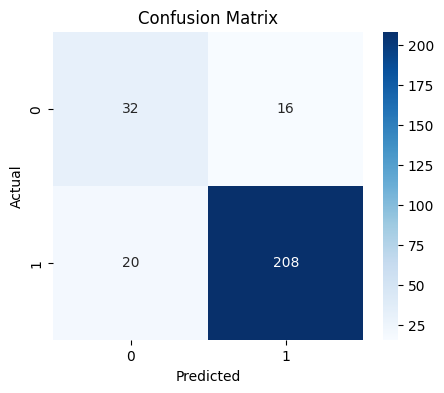

In [13]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


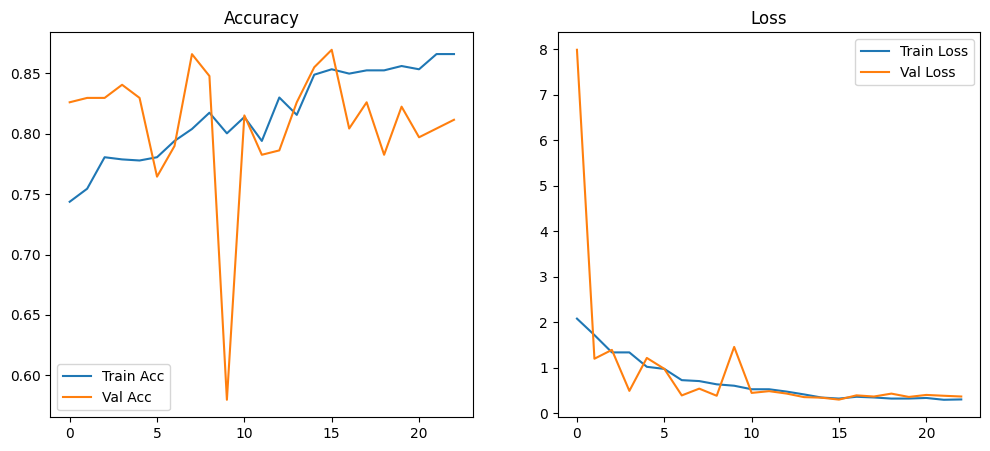

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()